In [66]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch

### Brute force feature matching with SIFT 

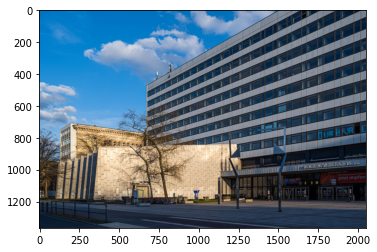

In [42]:
img1 = cv.imread('TUH.jpg')
img2 = cv.imread('TUH2.jpg')
sift = cv.SIFT_create()

img1_rgb = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

plt.imshow(img1_rgb)
plt.show()

In [51]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [ ]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

In [45]:
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

In [46]:
img3 = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

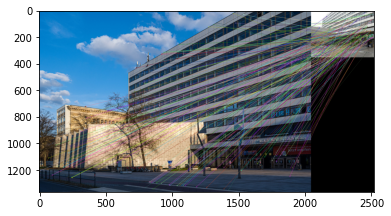

In [47]:
img3_rgb = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
cv.imwrite('combination2.jpg', img3_rgb)
plt.imshow(img3_rgb)
plt.show()

### Brute force with ORB (binary) descriptors

In [52]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [55]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

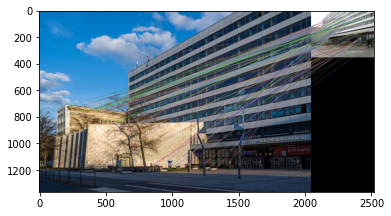

In [58]:
#drawing the first n found matches
n = 100
img3 = cv.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    matches[:n],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
img3_rgb = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
cv.imwrite('combination2ORB.jpg', img3_rgb)
plt.imshow(img3_rgb)
plt.show()

### Using FLANN to match
Flann stands for FAST APPROXIMATE NEAREST NEIGHBORS WITH AUTOMATIC ALGORITHM CONFIGURATION

In [59]:
FLANN_INDEX_LSH = 6
index_params = dict(
    algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2
)

search_params = dict(checks=50)
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [61]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

In [63]:
#fixing 'good' matches
matchesMask = [[0, 0] for i in range(len(matches))]

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

In [64]:
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0),
    matchesMask=matchesMask,
    flags=cv.DrawMatchesFlags_DEFAULT,
)

img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

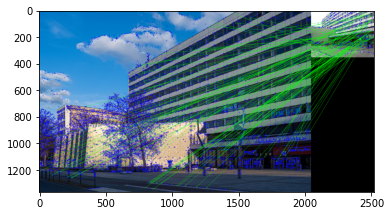

In [65]:
img3_rgb = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
cv.imwrite('combination2FLINN.jpg', img3_rgb)
plt.imshow(img3_rgb)
plt.show()

### Local Feature Matching with Transformers (LoFTR)

In [68]:
import kornia as K
import kornia.feature as KF
from kornia_moons.viz import draw_LAF_matches

In [69]:
#get and resize image 

from kornia.feature import LoFTR

img1 = K.io.load_image('TUH.jpg', K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('TUH2.jpg', K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

In [70]:
matcher = LoFTR(pretrained="outdoor")

#LoFTR only works for greyscale, so convert
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to C:\Users\JoCraft/.cache\torch\hub\checkpoints\loftr_outdoor.ckpt
100.0%


In [71]:
#lets inference using LoFTR
with torch.inference_mode():
    correspondences = matcher(input_dict)

In [72]:
#cleaning
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv.findFundamentalMat(mkpts0, mkpts1, cv.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

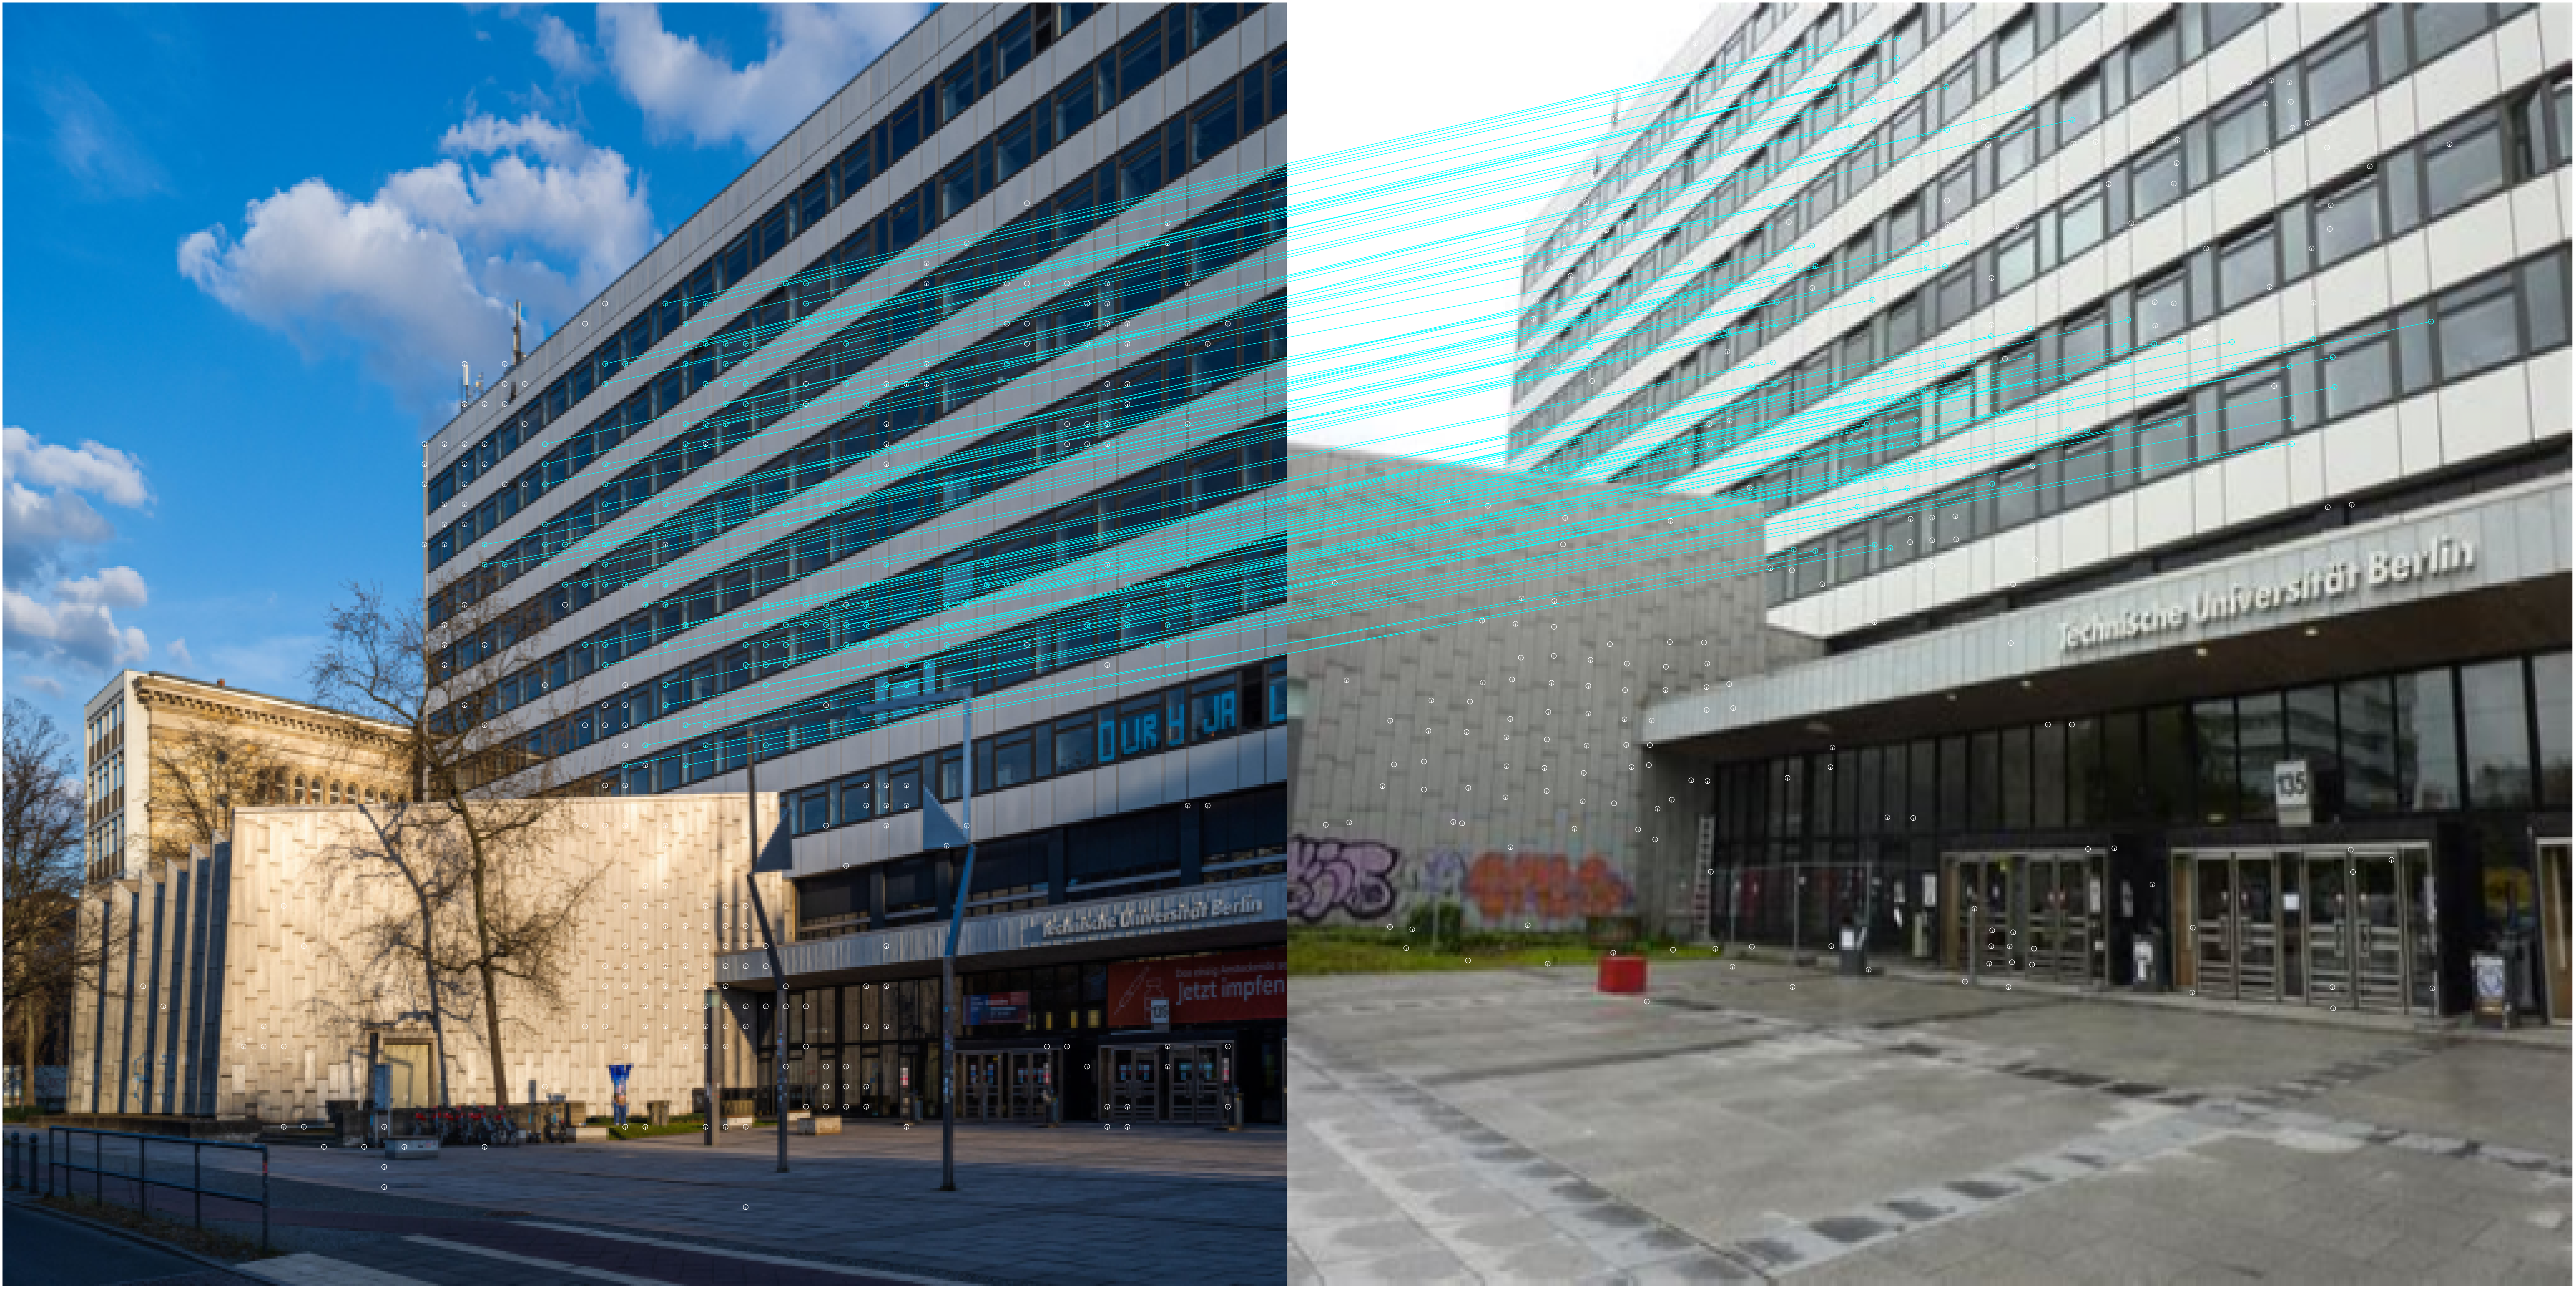

True

In [98]:
fig, ax = plt.subplots(figsize=(100, 50))
ax.axis('off')
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        #play around with color that best suits the image
        "inlier_color": (0, 1, 1, 1),
        "tentative_color": None,
        "feature_color": (1, 1, 1, 1),
        "vertical": False,
    },
    ax=ax,
)
#remove withespace
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
# Save the image using OpenCV
fig.canvas.draw()
img_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img_plot = img_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
plt.show(fig)
plt.close(fig)  # Close the figure to free memory

# Convert from RGB to BGR for OpenCV
img_plot_bgr = cv.cvtColor(img_plot, cv.COLOR_RGB2BGR)

# Save the image using OpenCV
cv.imwrite('combination2LoFTR.jpg', img_plot_bgr)

Recources: https://github.com/zju3dv/LoFTR and https://github.com/flann-lib/flann - LoFTR and FLANN GitHub 